# Steps

## [Libraries](#1.-Import-the-Libraries)
## [Analysis](#2.-Preliminary-Analysis)
## [Preprocessing]

# 🚌 Bus Demand Forecasting Hackathon

## 📌 Problem Statement

Accurately forecasting demand for bus journeys is a complex task due to the influence of multiple factors. These include:

- **Holiday calendars**
- **Wedding seasons**
- **Long weekends**
- **School vacations**
- **Exam schedules**
- **Day-of-week effects**
- **Regional holidays** (impact varies by region)

> Not all holidays cause significant changes in demand, making this a non-trivial modeling problem.

---

## 🎯 Objective

Develop a predictive model that forecasts the **total number of seats booked** for a given **route** and **date of journey**, exactly **15 days before the travel date**.

---

## 📂 Provided Data

You will be given historical data from the platform, which includes:

- `seats_booked`: Number of seats booked (actual demand)
- `date_of_journey`: The actual travel date
- `date_of_issue`: The date when the ticket was booked
- `search_data`: Number of user searches for a specific journey on a given booking date

---

## 🧠 Challenge Details

You need to predict the **final demand (total seats booked)** for each route, **15 days in advance** of the travel date.

### ✅ Example

- **Route**: Source City "A" → Destination City "B"
- **Date of Journey (DOJ)**: `30-Jan-2025`
- **Prediction Date**: `16-Jan-2025` (15 days prior to DOJ)

Your model should predict the **total expected bookings** on the prediction date for the journey date.

---

## 📥 Data Access

Download the training and testing datasets from the links provided at the bottom of the problem statement.

---

## 🔧 Next Steps

1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Model Building
4. Evaluation and Validation
5. Final Predictions



# Data Collection

Data - https://www.analyticsvidhya.com/datahack/contest/redbus-data-decode-hackathon-2025/
1. train_csv => rows - 67200, columns - 4
  - ['doj', 'srcid', 'destid', 'final_seatcount']
2. test_csv  => rows - 5900, columns - 4
  - ['route_key', 'doj', 'srcid', 'destid']
3. transactions.csv => rows - 22661000, columns - 11
  - ['doj', 'doi', 'srcid', 'destid', 'srcid_region', 'destid_region',
       'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount',
       'dbd']

## Import the Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

## Import Data from csv files

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
transactions_data = pd.read_csv("transactions.csv")

In [3]:
train_df = train_data.copy()
test_df = test_data.copy()
test_df = test_df.drop('route_key', axis = 1)
trans_df = transactions_data.copy()

In [4]:
print("train shape ->", train_df.shape)
print("transactions shape ->", trans_df.shape)
print("test shape ->", test_df.shape)

train shape -> (67200, 4)
transactions shape -> (2266100, 11)
test shape -> (5900, 3)


# Data Transformation

## Merge data 

In [5]:
transaction_15 = trans_df[trans_df['dbd'] == 15]

features = transaction_15[['doj', 'srcid', 'destid', 'srcid_region', 'destid_region',
       'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount']]

train_df = train_df.merge(features, on = ['doj', 'srcid', 'destid'], how = 'left')
test_df = test_df.merge(features, on = ['doj', 'srcid', 'destid'], how = 'left')

## Transform datatypes of doj columns

In [6]:
dfs = [train_df, test_df]

for df in dfs:
    df['doj'] = pd.to_datetime(df['doj'], format = '%Y-%m-%d')

# Understand the Data

## info() of dataframes

In [7]:
for i in dfs:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   doj                 67200 non-null  datetime64[ns]
 1   srcid               67200 non-null  int64         
 2   destid              67200 non-null  int64         
 3   final_seatcount     67200 non-null  float64       
 4   srcid_region        67200 non-null  object        
 5   destid_region       67200 non-null  object        
 6   srcid_tier          67200 non-null  object        
 7   destid_tier         67200 non-null  object        
 8   cumsum_seatcount    67200 non-null  float64       
 9   cumsum_searchcount  67200 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 5.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 9 columns):
 #   Column              No

## Check for Null values

In [8]:
for i in dfs:   
    print(i.isna().sum(),'\n')

doj                   0
srcid                 0
destid                0
final_seatcount       0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dtype: int64 

doj                   0
srcid                 0
destid                0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dtype: int64 



### Insight
- There are no Nulll values

## Check for duplicates

In [9]:
for i in dfs:
    print(i.duplicated().sum())

0
0


### Insights 
- No Duplicates

## Describe the DataFrames

In [10]:
for i in dfs:
    print(i.describe())

                                 doj         srcid        destid  \
count                          67200  67200.000000  67200.000000   
mean   2024-01-30 11:59:59.999999744     29.550000     29.750000   
min              2023-03-01 00:00:00      1.000000      1.000000   
25%              2023-08-15 18:00:00     14.750000     15.750000   
50%              2024-01-30 12:00:00     36.000000     34.500000   
75%              2024-07-16 06:00:00     45.000000     45.000000   
max              2024-12-31 00:00:00     48.000000     48.000000   
std                              NaN     16.670082     15.938986   

       final_seatcount  cumsum_seatcount  cumsum_searchcount  
count     67200.000000      67200.000000        67200.000000  
mean       2001.729464         52.964524         1845.007054  
min           2.000000          0.000000            0.000000  
25%        1252.000000          4.000000          330.000000  
50%        1685.000000         16.000000          742.000000  
75%      

# Exploratory Data Analysis

In [25]:
# Grouping and aggregating average seat count
summary = train_df.groupby(['doj_year', 'doj_month', 'doj_dayofweek'])['cumsum_seatcount'].agg(['mean', 'sum', 'count']).reset_index()

# Rename columns for clarity
summary.columns = ['Year', 'Month', 'DayOfWeek', 'AvgSeatCount', 'TotalSeatCount', 'TripCount']
print(summary)


     Year  Month  DayOfWeek  AvgSeatCount  TotalSeatCount  TripCount
0    2023      3          0       18.9000          7560.0        400
1    2023      3          1       20.0800          8032.0        400
2    2023      3          2       19.8500          9925.0        500
3    2023      3          3       21.6420         10821.0        500
4    2023      3          4       33.5640         16782.0        500
..    ...    ...        ...           ...             ...        ...
149  2024     12          2       70.4875         28195.0        400
150  2024     12          3       75.7425         30297.0        400
151  2024     12          4      107.5650         43026.0        400
152  2024     12          5      109.1975         43679.0        400
153  2024     12          6       95.3720         47686.0        500

[154 rows x 6 columns]


In [39]:
x = train_df.groupby('doj_year').agg(
    trips=('cumsum_seatcount', 'count'),
    total_cumsum_seatcount=('cumsum_seatcount', 'sum'),
    total_final_seatcount=('final_seatcount', 'sum')
).reset_index()

print(x)


   doj_year  trips  total_cumsum_seatcount  total_final_seatcount
0      2023  30600               1510253.0             55654541.0
1      2024  36600               2048963.0             78861679.0


In [40]:
x = train_df.groupby('doj_month').agg(
    trips=('cumsum_seatcount', 'count'),
    total_cumsum_seatcount=('cumsum_seatcount', 'sum'),
    total_final_seatcount=('final_seatcount', 'sum')
).reset_index()

print(x)


    doj_month  trips  total_cumsum_seatcount  total_final_seatcount
0           1   3100                262007.0              6390746.0
1           2   2900                101946.0              5659572.0
2           3   6200                227989.0             10928412.0
3           4   6000                286984.0             11663207.0
4           5   6200                332222.0             13721078.0
5           6   6000                228263.0             12512741.0
6           7   6200                135758.0             10748626.0
7           8   6200                277368.0             12009322.0
8           9   6000                241928.0             11457971.0
9          10   6200                499133.0             12350542.0
10         11   6000                445423.0             12715097.0
11         12   6200                520195.0             14358906.0


In [41]:
x = train_df.groupby('doj_year', 'doj_month').agg(
    trips=('cumsum_seatcount', 'count'),
    total_cumsum_seatcount=('cumsum_seatcount', 'sum'),
    total_final_seatcount=('final_seatcount', 'sum')
).reset_index()

print(x)


ValueError: No axis named doj_month for object type DataFrame

<Axes: title={'center': 'Journeys per Day'}, xlabel='doj'>

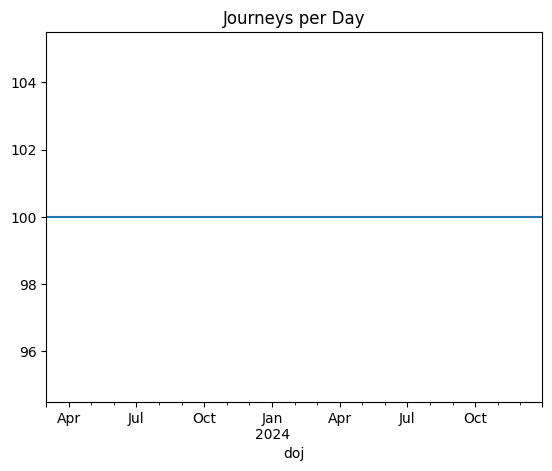

In [11]:
# Journey count over time
train_df.groupby('doj').size().plot(title='Journeys per Day')

In [12]:
df['route'] = df['srcid_region'] + " → " + df['destid_region']
top_routes = df['route'].value_counts().head(10)
print(top_routes)

route
Tamil Nadu → Tamil Nadu                      1062
Maharashtra and Goa → Maharashtra and Goa     944
Andhra Pradesh → Andhra Pradesh               767
Rest of North → Delhi                         413
Delhi → Rest of North                         354
East 1 → East 1                               354
Karnataka → Tamil Nadu                        295
Tamil Nadu → Karnataka                        295
Karnataka → Andhra Pradesh                    236
Andhra Pradesh → Karnataka                    236
Name: count, dtype: int64


In [13]:
region_stats = train_df.groupby(['srcid_region', 'destid_region'])[['final_seatcount', 'cumsum_searchcount']].mean().sort_values(by='cumsum_searchcount', ascending=False)
print(region_stats.head())


                                    final_seatcount  cumsum_searchcount
srcid_region        destid_region                                      
Maharashtra and Goa Madhya Pradesh      1996.629464         3252.313988
Karnataka           Kerala              1874.040179         3185.372024
Tamil Nadu          Tamil Nadu          2520.560599         2944.916088
Karnataka           Andhra Pradesh      2442.611235         2809.062872
Delhi               Rest of North       1483.737351         2370.710069


In [14]:
tier_stats = train_df.groupby(['srcid_tier', 'destid_tier'])[['final_seatcount', 'cumsum_searchcount']].mean()
print(tier_stats)


                        final_seatcount  cumsum_searchcount
srcid_tier destid_tier                                     
Tier 1     Tier 1           2323.461434         1866.709387
           Tier 3           1689.240434         2012.462160
           Tier 4           1867.977679         2699.462798
           Tier2            2020.308837         2349.171016
Tier 3     Tier 1           1641.160218          914.242808
Tier 4     Tier 1           1865.433036         1476.955357
           Tier2            1656.469494         1097.142857
Tier2      Tier 1           2003.424045         1447.355593
           Tier 4           2192.392857         6680.345238
           Tier2            1525.977927         1180.756696


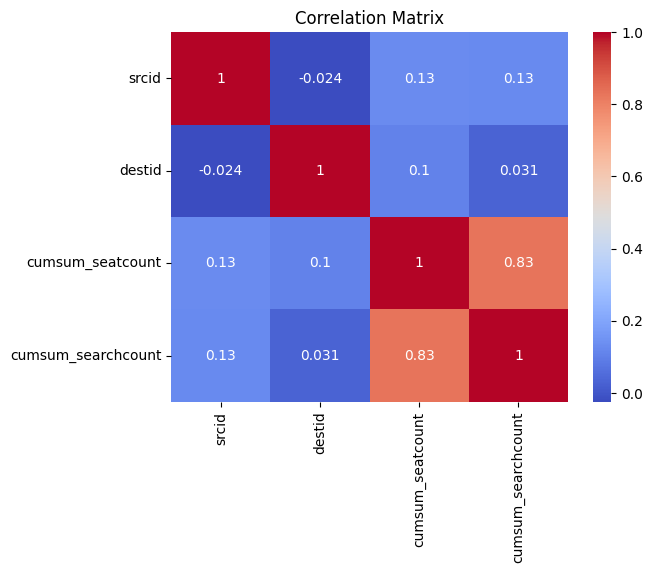

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


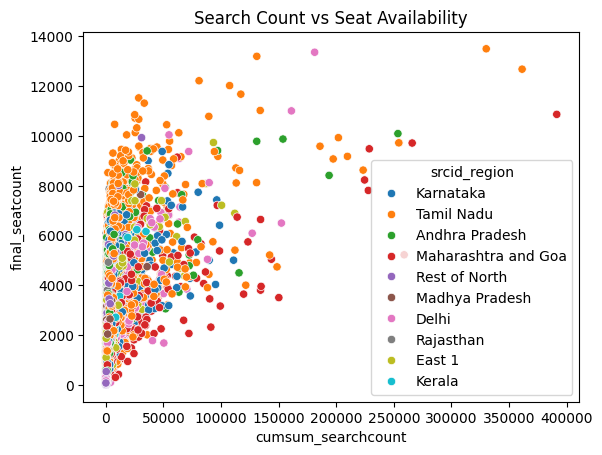

In [16]:
sns.scatterplot(data=train_df, x='cumsum_searchcount', y='final_seatcount', hue='srcid_region')
plt.title("Search Count vs Seat Availability")
plt.show()


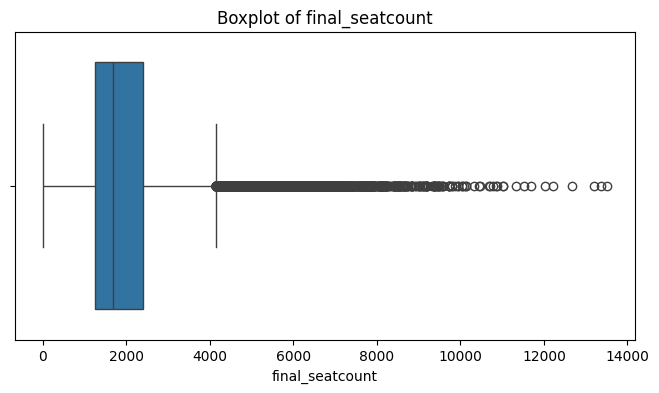

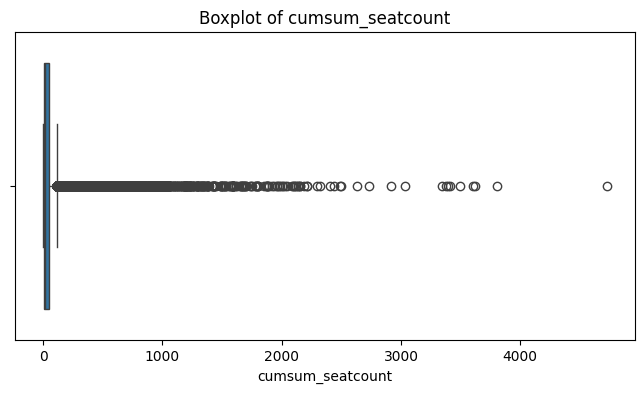

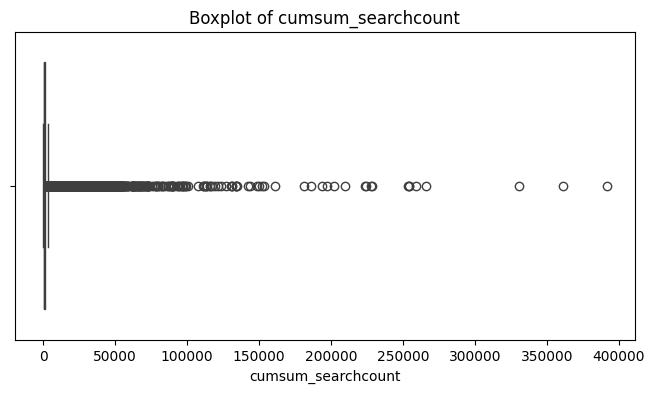

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['final_seatcount', 'cumsum_seatcount', 'cumsum_searchcount']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=train_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()


# Preprocessing

## Adding few columns

In [18]:
dfs = [train_df, test_df]

for df in dfs:
    
    # Extracting new columns with date columns
    df['doj' + '_year'] = df['doj'].dt.year
    df['doj' + '_month'] = df['doj'].dt.month
    df['doj' + '_day'] = df['doj'].dt.day
    df['doj' + '_dayofweek'] = df['doj'].dt.dayofweek
    df['doj' + '_isweekend'] = df['doj'].dt.dayofweek.isin([5,6]).astype(int)

## Ordinal Encoder

In [19]:
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'O']
# ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']

encoder = OrdinalEncoder(dtype = int)

train_df[categorical_columns] = encoder.fit_transform(train_df[categorical_columns])
test_df[categorical_columns] = encoder.fit_transform(test_df[categorical_columns])

## Deleting doj column

In [20]:
train_df = train_df.drop(['doj'], axis =1)
test_df = test_df.drop(['doj'], axis = 1)

## Data Preparation

In [21]:
X = train_df.drop(['final_seatcount'], axis = 1)
y = train_df['final_seatcount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
print(train_df.columns)
print(test_df.columns)

Index(['srcid', 'destid', 'final_seatcount', 'srcid_region', 'destid_region',
       'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount',
       'doj_year', 'doj_month', 'doj_day', 'doj_dayofweek', 'doj_isweekend'],
      dtype='object')
Index(['srcid', 'destid', 'srcid_region', 'destid_region', 'srcid_tier',
       'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount', 'route',
       'doj_year', 'doj_month', 'doj_day', 'doj_dayofweek', 'doj_isweekend'],
      dtype='object')


### model testing

In [23]:
model = XGBRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # 392
rmse

np.float64(392.09103789169905)